In [2]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from ipdb import set_trace as bp

np.set_printoptions(linewidth=160, precision=2)

In [3]:
@jit(nopython=True)
def value_iteration_with_policy(
    R: np.ndarray,
    T_agent: np.ndarray,
    gamma: float,
    tol: float = 1e-6,
):
    n_states = R.shape[0]
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=np.int32)
    while True:
        V_new = np.zeros(n_states)
        for s in range(n_states):
            action_values = R[s] + gamma * np.sum(T_agent[s] * V, axis=1)
            best_action = np.argmax(action_values)
            V_new[s] = action_values[best_action]
            policy[s] = best_action
        if np.max(np.abs(V - V_new)) < tol:
            break
        V = V_new
    V = V / np.max(V) * R.max()
    return V, policy

In [4]:
@jit(nopython=True)
def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
    trajectory = []
    current_state = start_state
    n_states = len(policy)

    while len(trajectory) < max_steps:
        if current_state in absorbing_states:
            trajectory.append((current_state, None, None))  # Append the absorbing state
            break
        chosen_action = policy[current_state]
        # Manually sample next_state based on T_true
        cumulative_prob = 0.0
        rand_num = np.random.rand()
        next_state = 0
        for s in range(n_states):
            cumulative_prob += T_true[current_state, chosen_action, s]
            if rand_num < cumulative_prob:
                next_state = s
                break

        trajectory.append((current_state, chosen_action, next_state))
        current_state = next_state
    return trajectory

In [48]:
@jit(nopython=True)
def generate_n_trajectories(
    T_true, policy, absorbing_states, n_trajectories=100, max_steps=100
):
    trajectories = []
    for _ in range(n_trajectories):
        trajectories.append(
            generate_trajectory(T_true, policy, absorbing_states, max_steps=max_steps)
        )
    return trajectories

In [5]:
def make_absorbing(R, *Ts):
    reward_indices = np.where(R > 0)[0]
    for T in Ts:
        T[reward_indices, :, :] = 0
        T[reward_indices, :, reward_indices] = 1

In [59]:
@jit(nopython=True)
def transition_matrix(N, M, p):
    n_states = N * M
    n_actions = 4  # N, E, S, W

    # Initialize the transition matrix
    T = np.zeros((n_states, n_actions, n_states))

    # Helper function to convert 2D grid indices to 1D state index
    to_s = lambda i, j: i * M + j

    # Populate the transition matrix
    for i in range(N):
        for j in range(M):
            s = to_s(i, j)

            # Neighboring states
            neighbors = {
                "N": to_s(i - 1, j) if i > 0 else s,
                "E": to_s(i, j + 1) if j < M - 1 else s,
                "S": to_s(i + 1, j) if i < N - 1 else s,
                "W": to_s(i, j - 1) if j > 0 else s,
            }

            # Set transition probabilities
            for a, action in enumerate(["N", "E", "S", "W"]):
                T[s, a, neighbors[action]] = p
                for other_action in set(["N", "E", "S", "W"]) - {action}:
                    T[s, a, neighbors[other_action]] += (1 - p) / 3

    return T

In [7]:
def plot_trajectories(N, M, trajectories, reward_matrix):
    plt.figure(figsize=(M, N))

    # Plot rewards as heatmap
    plt.imshow(reward_matrix.reshape(N, M), cmap="viridis", origin="upper")

    # Plot trajectories
    for traj in trajectories:
        x_coords, y_coords = [], []
        for s, _, _ in traj:
            x, y = divmod(s, M)
            x_coords.append(x)
            y_coords.append(y)

        # Plot the trajectories with a color that stands out
        plt.plot(y_coords, x_coords, marker="o", color="white", alpha=0.5)

    plt.colorbar(label="Reward")
    plt.gca().xaxis.tick_top()
    plt.show()

In [8]:
def plot_value_and_policy(
    value_function, policy, grid_shape, absorbing_states, title=""
):
    plt.figure(figsize=grid_shape[::-1])
    plt.imshow(
        value_function.reshape(grid_shape),
        cmap="viridis",
        origin="upper",
        interpolation="nearest",
    )
    plt.colorbar(label="Value")

    for s, val in enumerate(value_function):
        if s in absorbing_states:
            continue  # Skip arrows for absorbing states

        row, col = divmod(s, grid_shape[1])
        action = policy[s]
        if action == 0:  # N
            dx, dy = 0, -0.4
        elif action == 1:  # E
            dx, dy = 0.4, 0
        elif action == 2:  # S
            dx, dy = 0, 0.4
        elif action == 3:  # W
            dx, dy = -0.4, 0
        plt.arrow(col, row, dx, dy, head_width=0.1, head_length=0.1, fc="r", ec="r")

    plt.title(title)
    plt.show()

In [62]:
# Make function that counds state visit frequencies from trajectories
@jit(nopython=True)
def count_state_visits(trajectories, n_states):
    state_visits = np.zeros(n_states)
    for traj in trajectories:
        for s, _, _ in traj:
            state_visits[s] += 1
    return state_visits / state_visits.sum()

### Define a world where different $\gamma$ leads to different optimal policies


In [10]:
# World definition

# Key: S: start, Number: Reward size

# Idea is that the agent goes right and at every step decides whether to
# take the immediate reward or go for a bigger reward

#   0 1 2 3 4 5
# 0 S . . . . .
# 1 1 2 3 4 5 6

In [39]:
N, M = 2, 6  # dimensions of the gridworld

n_states, n_actions = N * M, 4
R = np.array(
    [
        [0] * 6,
        range(1, 7),
    ]
).flatten()

p_agent = 0.5  # Agent's transition probability that we're interested in learning
gamma_agent = 0.9  # Agent's discount factor that we're interested in learning

T_agent = transition_matrix(N, M, p=p_agent)  # Agent's transition matrix
T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
absorbing_states = np.where(R > 0)[0]  # Absorbing states

In [40]:
make_absorbing(R, T_agent, T_true)

In [41]:
# Generate V and policy
V, policy = value_iteration_with_policy(R, T_agent, gamma=gamma_agent)

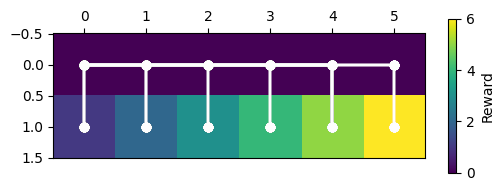

In [42]:
# Generate trajectories
trajectories = [
    generate_trajectory(T_true, policy, absorbing_states) for _ in range(1000)
]

plot_trajectories(N, M, trajectories, R)

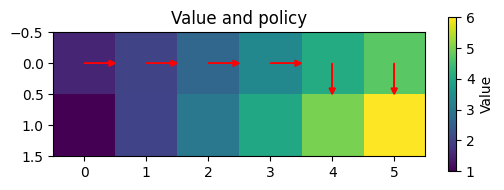

array([[1.51, 2.02, 2.65, 3.33, 4.07, 4.73],
       [1.  , 2.  , 3.  , 4.  , 5.  , 6.  ]])

In [43]:
plot_value_and_policy(V, policy, (N, M), absorbing_states, title="Value and policy")
V.reshape((N, M))

In [44]:
empirical_freq = count_state_visits(trajectories, n_states)

with np.printoptions(formatter={"all": "{:.2f}%".format}):
    print(empirical_freq.reshape((N, M)) * 100)

[[18.23% 17.31% 16.50% 15.78% 15.11% 0.61%]
 [0.76% 0.71% 0.53% 0.56% 13.38% 0.53%]]


In [63]:
@jit(nopython=True)
def find_best_params(
    R,
    T_true,
    absorbing_states,
    empirical_freq,
    n_states,
    n_trajectories=1000,
    N=2,
    M=6,
):
    # Step 1: Generate parameter grid
    gamma_values = np.linspace(0.01, 0.99, num=100)
    p_values = np.linspace(0.01, 0.99, num=100)

    # Initialize array to store MSE values
    mse_values = np.zeros(len(gamma_values) * len(p_values))

    # Loop through each pair of parameters
    for i, gamma in enumerate(gamma_values):
        for j, p in enumerate(p_values):
            # Step 2: Create T_agent using p
            T_agent = transition_matrix(N, M, p=p)

            # Step 3: Solve environment to get value function and policy
            V, policy = value_iteration_with_policy(R, T_agent, gamma=gamma)

            # Step 4: Simulate trajectories to get simulated visitation frequencies
            simulated_freq = count_state_visits(
                generate_n_trajectories(
                    T_true, policy, absorbing_states, n_trajectories=n_trajectories
                ),
                n_states,
            )
            # Step 5: Compute MSE
            mse = np.mean((simulated_freq - empirical_freq) ** 2)

            # Store MSE
            mse_values[i * len(p_values) + j] = mse

    return gamma_values, p_values, mse_values

In [64]:
gamma_values, p_values, mse_values = find_best_params(
    R, T_true, absorbing_states, empirical_freq, n_states, n_trajectories=1000
)

# Step 6: Find parameters that minimize MSE
param_grid = list(product(gamma_values, p_values))
min_mse_idx = np.argmin(mse_values)
best_gamma, best_p = param_grid[min_mse_idx]

print(f"Best gamma: {best_gamma}, Best p: {best_p}")

Best gamma: 0.98010101010101, Best p: 0.31686868686868686


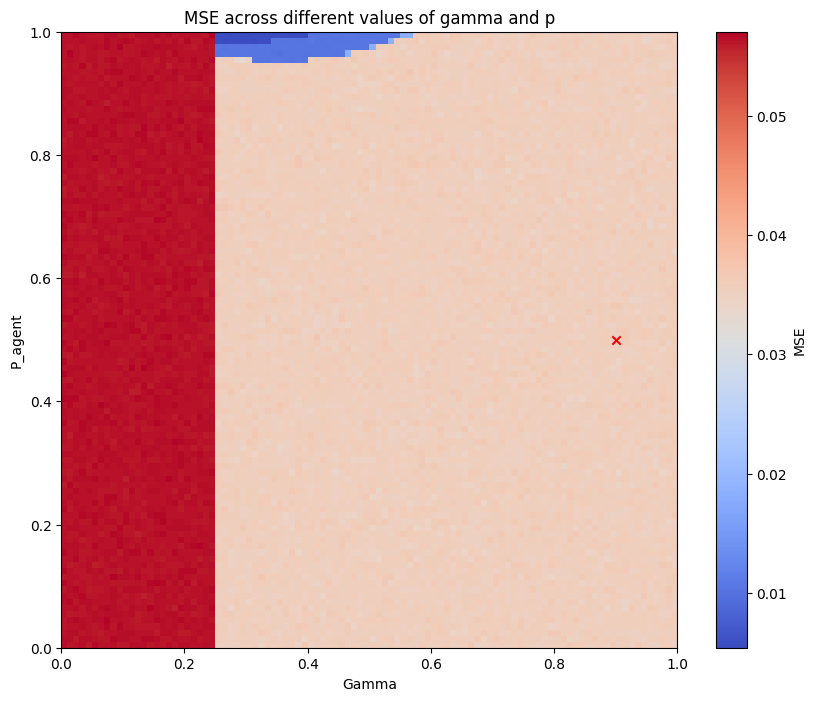

In [65]:
plt.figure(figsize=(10, 8))
plt.imshow(
    mse_values.reshape((len(gamma_values), len(p_values))),
    interpolation="nearest",
    cmap="coolwarm",
    origin="lower",
    extent=[0, 1, 0, 1],
)
plt.colorbar(label="MSE")
plt.xlabel("Gamma")
plt.ylabel("P_agent")
plt.title("MSE across different values of gamma and p")

# Mark the true gamma and p values
plt.scatter(gamma_agent, p_agent, color="red", marker="x")

plt.show()